# Training Deep Neural Networks

## Importing Libraries

In [1]:
import sys
import sklearn
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

## The Vanishing / Exploding Gradients Problem

- In most cases, during back propagation, gradients keep reducing as the algorithm progresses to lower layers of the NN. This leaves the lower layer connection weights virtually unchanged and training fails to converge. This is known as the **Vanishing Gradients** problem.
- Conversely, the opposite can happen and the gradients can keep growing during back-prop. causing the algorithm to diverge. This is known as the **Exploding Gradients** problem, which is known to surface in RNNs.
- Bengio and Glorot (2010) found that the combination of logistic sigmoid activation and weight initialization (using a normal distribution, with mean=0 and std=1) caused the variance of the outputs of each layers was much greater than the variance of the inputs.
- The variance keeps increasing after each layer until the activation function saturates at the top layers. The saturation is further worsened by the fact that the logistic function has a mean of 0.5 and not 0. (tanh has mean of 0 and is a slight improvement over the sigmoid function.)

In [2]:
# Creating a visualization of the Vanishing / Exploding Gradients problem
def logit(z):
    return 1 / (1 + np.exp(-z))

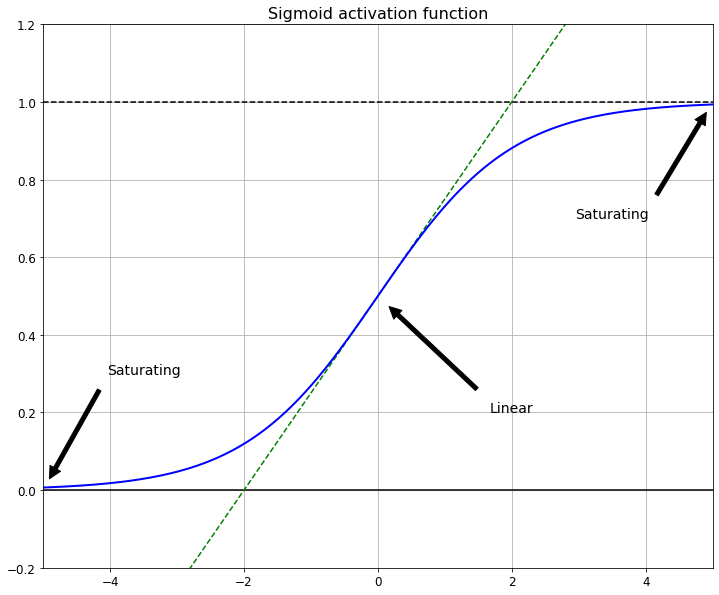

In [3]:
z = np.linspace(-5, 5, 200)

plt.figure(figsize=(12,10))
plt.plot([-5, 5], [0, 0], "k-")
plt.plot([-5, 5], [1, 1], "k--")
plt.plot([0, 0], [-0.2, -0.2], "k-")
plt.plot([-5, 5], [-3/4, 7/4], "g--")
plt.plot(z, logit(z), "b-", linewidth=2)

props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props, fontsize=14, ha="center")
plt.grid(True)
plt.title("Sigmoid activation function", fontsize=16)
plt.axis([-5, 5, -0.2, 1.2])
plt.show();

## Glorot/Xavier and He Initialization

- Connection weights of each layer must be initialized randomly in order to ensure that the variance of the output layers is equal to variance of inputs.
- Gradients must also have equal variance before and after flowing through a layer in the reverse direction.
- Details are available in the following [paper](https://calibre-internal.invalid/OEBPS/ch11.html#idm46028932885000).

In [4]:
# Getting all initializers in Keras
[name for name in dir(keras.initializers) if not name.startswith("_")]

['Constant',
 'GlorotNormal',
 'GlorotUniform',
 'Identity',
 'Initializer',
 'Ones',
 'Orthogonal',
 'RandomNormal',
 'RandomUniform',
 'TruncatedNormal',
 'VarianceScaling',
 'Zeros',
 'constant',
 'deserialize',
 'get',
 'glorot_normal',
 'glorot_uniform',
 'he_normal',
 'he_uniform',
 'identity',
 'lecun_normal',
 'lecun_uniform',
 'ones',
 'orthogonal',
 'serialize',
 'zeros']

**Let's also get the list of initializers in Pytorch**

In [5]:
import torch

In [6]:
[name for name in dir(torch.nn.init) if not (name.startswith("_") or name.endswith("_"))]

['calculate_gain',
 'constant',
 'dirac',
 'division',
 'eye',
 'kaiming_normal',
 'kaiming_uniform',
 'math',
 'normal',
 'orthogonal',
 'sparse',
 'torch',
 'uniform',
 'warnings',
 'xavier_normal',
 'xavier_uniform']

## Non-saturating Activation Functions

### Leaky ReLU

In [7]:
def leaky_relu(z, alpha=0.01):
    return np.maximum(alpha*z, z)

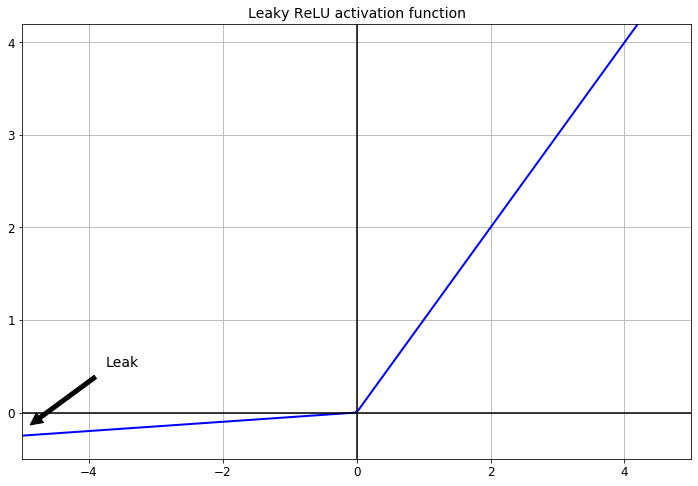

In [12]:
plt.figure(figsize=(12, 8))
plt.plot(z, leaky_relu(z, 0.05), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.2), arrowprops=props, fontsize=14, ha="center")
plt.title("Leaky ReLU activation function", fontsize=14)
plt.axis([-5, 5, -0.5, 4.2])
plt.show()

In [13]:
# This is a list of keras activations
[m for m in dir(keras.activations) if not m.startswith("_")]

['deserialize',
 'elu',
 'exponential',
 'get',
 'hard_sigmoid',
 'linear',
 'relu',
 'selu',
 'serialize',
 'sigmoid',
 'softmax',
 'softplus',
 'softsign',
 'tanh']

In [16]:
# This is a list of keras relu layers
[m for m in dir(keras.layers) if "relu" in m.lower()]

['LeakyReLU', 'PReLU', 'ReLU', 'ThresholdedReLU']

Training a neural net on the Fashion MNIST dataset using leaky ReLU:

In [24]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()

In [26]:
# Dividing the images by 255.0 to normalize them i.e. rescaling them from 0-255 to 0-1
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

In [30]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, kernel_initializer="he_normal"), # HE normalization is named after the author of the original paper.
    keras.layers.LeakyReLU(),
    keras.layers.Dense(100, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(10, activation="softmax")
])

In [31]:
# Model architecture
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 300)               235500    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 300)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)               30100     
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 100)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
__________________________________________________

In [32]:
# Compiling the model and specifying a loss function, SGD optimizer
# and evaluation metrics
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

In [33]:
# Training the model
history = model.fit(X_train, y_train, epochs=15,
               validation_data = (X_valid, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/15
55000/55000 [==============================] - 2s 45us/sample - loss: 1.2806 - accuracy: 0.6250 - val_loss: 0.8882 - val_accuracy: 0.7152
Epoch 2/15
55000/55000 [==============================] - 2s 39us/sample - loss: 0.7954 - accuracy: 0.7374 - val_loss: 0.7134 - val_accuracy: 0.7648
Epoch 3/15
55000/55000 [==============================] - 2s 37us/sample - loss: 0.6816 - accuracy: 0.7727 - val_loss: 0.6356 - val_accuracy: 0.7882
Epoch 4/15
55000/55000 [==============================] - 2s 37us/sample - loss: 0.6215 - accuracy: 0.7935 - val_loss: 0.5922 - val_accuracy: 0.8012
Epoch 5/15
55000/55000 [==============================] - 2s 37us/sample - loss: 0.5830 - accuracy: 0.8081 - val_loss: 0.5596 - val_accuracy: 0.8172
Epoch 6/15
55000/55000 [==============================] - 2s 38us/sample - loss: 0.5553 - accuracy: 0.8155 - val_loss: 0.5338 - val_accuracy: 0.8238
Epoch 7/15
55000/55000 [==============================] -

**Trying PReLU instead of ReLU**

In [34]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(100, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(10, activation="softmax")
])

In [38]:
# Training the model, now with PReLU
history = model.compile(loss="sparse_categorical_crossentropy",
                        optimizer=keras.optimizers.SGD(lr=1e-3),
                        metrics=["accuracy"])

In [39]:
history = model.fit(X_train, y_train, epochs=15,
                    validation_data=(X_valid, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/15
55000/55000 [==============================] - 2s 44us/sample - loss: 1.3470 - accuracy: 0.6225 - val_loss: 0.9268 - val_accuracy: 0.7200
Epoch 2/15
55000/55000 [==============================] - 2s 38us/sample - loss: 0.8209 - accuracy: 0.7357 - val_loss: 0.7322 - val_accuracy: 0.7640
Epoch 3/15
55000/55000 [==============================] - 2s 38us/sample - loss: 0.6972 - accuracy: 0.7697 - val_loss: 0.6494 - val_accuracy: 0.7866
Epoch 4/15
55000/55000 [==============================] - 2s 39us/sample - loss: 0.6332 - accuracy: 0.7904 - val_loss: 0.6027 - val_accuracy: 0.8024
Epoch 5/15
55000/55000 [==============================] - 2s 38us/sample - loss: 0.5918 - accuracy: 0.8050 - val_loss: 0.5675 - val_accuracy: 0.8140
Epoch 6/15
55000/55000 [==============================] - 2s 39us/sample - loss: 0.5619 - accuracy: 0.8141 - val_loss: 0.5393 - val_accuracy: 0.8252
Epoch 7/15
55000/55000 [==============================] -

### ELU

In [40]:
def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

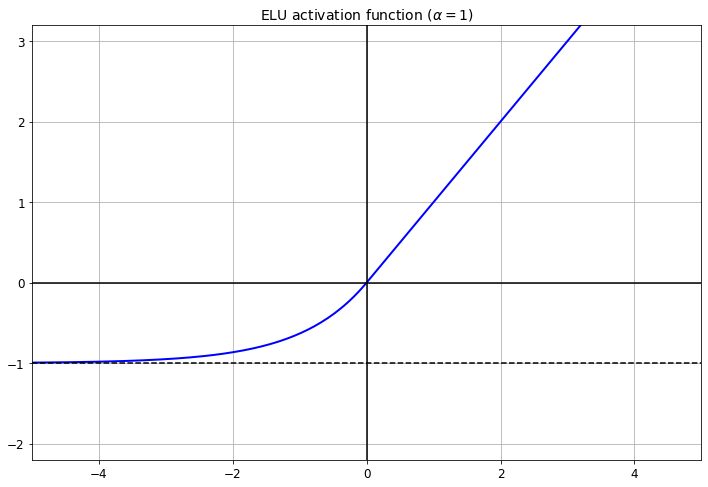

In [42]:
plt.figure(figsize=(12, 8))
plt.plot(z, elu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"ELU activation function ($\alpha=1$)", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])
plt.show()



The text states that the implementation of ELU in TensorFlow is trivial, simply specify the activation function when building each layer:

In [43]:
keras.layers.Dense(10, activation="elu")

### SELU

According to A. Geron, the SELU function is, at best, an experimental activation function:

_"This activation function was proposed in this great paper by Günter Klambauer, Thomas Unterthiner and Andreas Mayr, published in June 2017. During training, a neural network composed exclusively of a stack of dense layers using the SELU activation function and LeCun initialization will self-normalize: the output of each layer will tend to preserve the same mean and variance during training, which solves the vanishing/exploding gradients problem. As a result, this activation function outperforms the other activation functions very significantly for such neural nets, so you should really try it out. Unfortunately, the self-normalizing property of the SELU activation function is easily broken: you cannot use ℓ1 or ℓ2 regularization, regular dropout, max-norm, skip connections or other non-sequential topologies (so recurrent neural networks won't self-normalize). However, in practice it works quite well with sequential CNNs. If you break self-normalization, SELU will not necessarily outperform other activation functions."_